<a href="https://colab.research.google.com/github/amazon4b/Learning-Machine/blob/learner1/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [265]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [266]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [267]:
# 데이터프레임 불러오기
economics = pd.read_csv('./datasets/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [268]:
economics.drop(['장단기10년물국채/3개월금리차','신규실업수당청구','금융상태지수레버리지','제조업신규주문'],axis=1,inplace=True)

In [269]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매


In [271]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [272]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [273]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

In [274]:
# # 그래프 크기 조정
# plt.rcParams['font.family'] ='Malgun Gothic'
# 가로, 세로 = 30, 20  # 원하는 크기로 조절
# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# # 각 컬럼에 대한 서브 플롯 그리기
# for i, col in enumerate(economics.columns):
#     economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
#     axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# # 그래프 출력
# plt.show()

#### 스케일링

In [275]:
# 민멕스 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(economics)

# 데이터 변환
mMscaled_data = mMscaler.transform(economics)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(data = mMscaled_data, index = economics.index , columns = economics.columns)

In [276]:
# # 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
# 가로, 세로 = 30, 20  # 원하는 크기로 조절
# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# # 각 컬럼에 대한 서브 플롯 그리기
# for i, col in enumerate(mMscaled_data.columns):
#     mMscaled_data.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
#     axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# # 그래프 출력
# plt.show()

#### GaussianMixture 군집화 비교분석

In [277]:
pca_df0 = mMscaled_data.copy()

In [278]:
from sklearn.decomposition import PCA

pca = PCA()

pca_df = pd.DataFrame(pca.fit_transform(pca_df0))

# 주성분들이 설명하는 분산의 비율을 확인하는 코드
# Access explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Print or use the explained variance ratios
print("Explained Variance Ratios:")
print(explained_variance_ratios)

Explained Variance Ratios:
[0.47486627 0.18528129 0.13890905 0.05980781 0.03945728 0.02936114
 0.02662438 0.01594366 0.01311452 0.00692286 0.00604826 0.00366349]


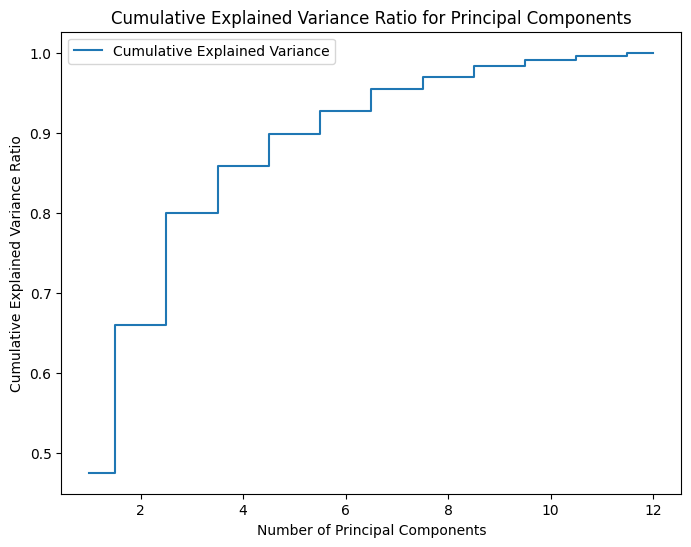

In [279]:
plt.figure(figsize=(8, 6))
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for Principal Components')
plt.legend()
plt.show()

# plt.step(list(range(1,10)), np.cumsum(pca.explained_variance_ratio_))
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Eigen Values')
# plt.ylabel('Ratio of Variance Explained')
# plt.title('Variance Covered by each Eigen Value')
# plt.show()

In [280]:
pca_df = pca_df.drop(columns = [7,8,9,10,11])
pca_df.head()

,0,1,2,3,4,5,6
0,-0.822012,0.369716,0.161866,-0.054982,-0.302402,-0.056911,-0.095982
1,-0.873760,0.363113,0.193319,-0.104235,-0.280930,-0.054163,-0.085926
2,-0.909069,0.247894,0.217418,-0.114760,-0.329716,0.145272,-0.117530
3,-0.949386,0.282315,0.267522,0.006774,-0.246777,0.352583,-0.084640
4,-0.934304,0.294915,0.259300,-0.130338,-0.403937,-0.162235,0.067947


In [281]:
# PCA한 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(pca_df)

# 데이터 변환
scaled_pca = mMscaler.transform(pca_df)

# 데이터 프레임으로 저장
scaled_pca = pd.DataFrame(data = scaled_pca, index = pca_df.index , columns = pca_df.columns)

In [282]:
scaled_pca

,0,1,2,3,4,5,6
0,0.065668,0.753955,0.475056,0.256606,0.125217,0.365264,0.320348
1,0.038989,0.748406,0.497495,0.213235,0.151697,0.368174,0.334068
2,0.020786,0.651579,0.514689,0.203968,0.091533,0.579361,0.290950
3,0.000000,0.680505,0.550434,0.310986,0.193816,0.798888,0.335821
4,0.007775,0.691094,0.544568,0.190250,0.000000,0.253733,0.543999
...,...,...,...,...,...,...,...
235,0.236399,0.170451,0.397957,0.449650,0.494207,0.400489,0.522970
236,0.235087,0.128080,0.378530,0.479030,0.466752,0.476706,0.414215
237,0.254693,0.217826,0.385363,0.529593,0.500461,0.516848,0.428131
238,0.255461,0.172713,0.342116,0.508544,0.475757,0.436842,0.429567


In [283]:
# pca0에는 어떤 피쳐가 영향력을 가장 크게 주는지 찾아내기
# pca하고 스케일링 해야됨
# 군집화하는데 영향을 크게 주는 피쳐가 있음 
# 클러스터0에서 가장 영향을 많이 주는 피쳐가 있음
# pca 목적 : 피쳐 상관성 때문에
# 국면 해석 분석에 대해서 논리적으로 설명해야됨

In [284]:
from sklearn.mixture import GaussianMixture
from numpy import unique
from numpy import where

# define the model : n_components=3 (cluster 갯수)
gmm = GaussianMixture(n_components=5, random_state=24)

# train the model
gmm_label = gmm.fit(scaled_pca).predict(scaled_pca)

# assign each data point to a cluster
scaled_pca['gmm_cluster'] = gmm_label

# get all of the unique clusters
gaussian_clusters = unique(scaled_pca['gmm_cluster'])
print(gaussian_clusters)

scaled_pca['gmm_cluster'].value_counts()

[0 1 2 3 4]


gmm_cluster
2    67
0    61
1    50
3    44
4    18
Name: count, dtype: int64

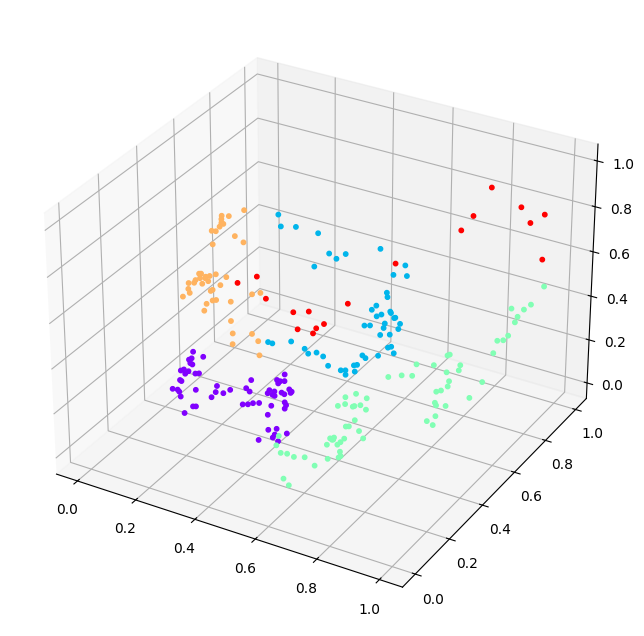

In [285]:
# 3차원으로 시각화하기

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

X = scaled_pca

# 데이터 scatterplot
ax.scatter(  X.iloc[:,0]
           , X.iloc[:,1]
           , X.iloc[:,2]
           , c = X.gmm_cluster
           , s = 10
           , cmap = "rainbow"
           , alpha = 1
          )

# centroid scatterplot
# ax.scatter(centers[:,0],centers[:,1],centers[:,2] ,c='black', s=200, marker='*')
plt.show()


In [286]:
# SAHM 데이터 불러오기 및 cluster 컬럼 추가
SAHM = pd.read_csv('./datasets/SAHMREALTIME.csv')
scaled_pca.reset_index(inplace=True)
SAHM['cluster'] = scaled_pca['gmm_cluster']

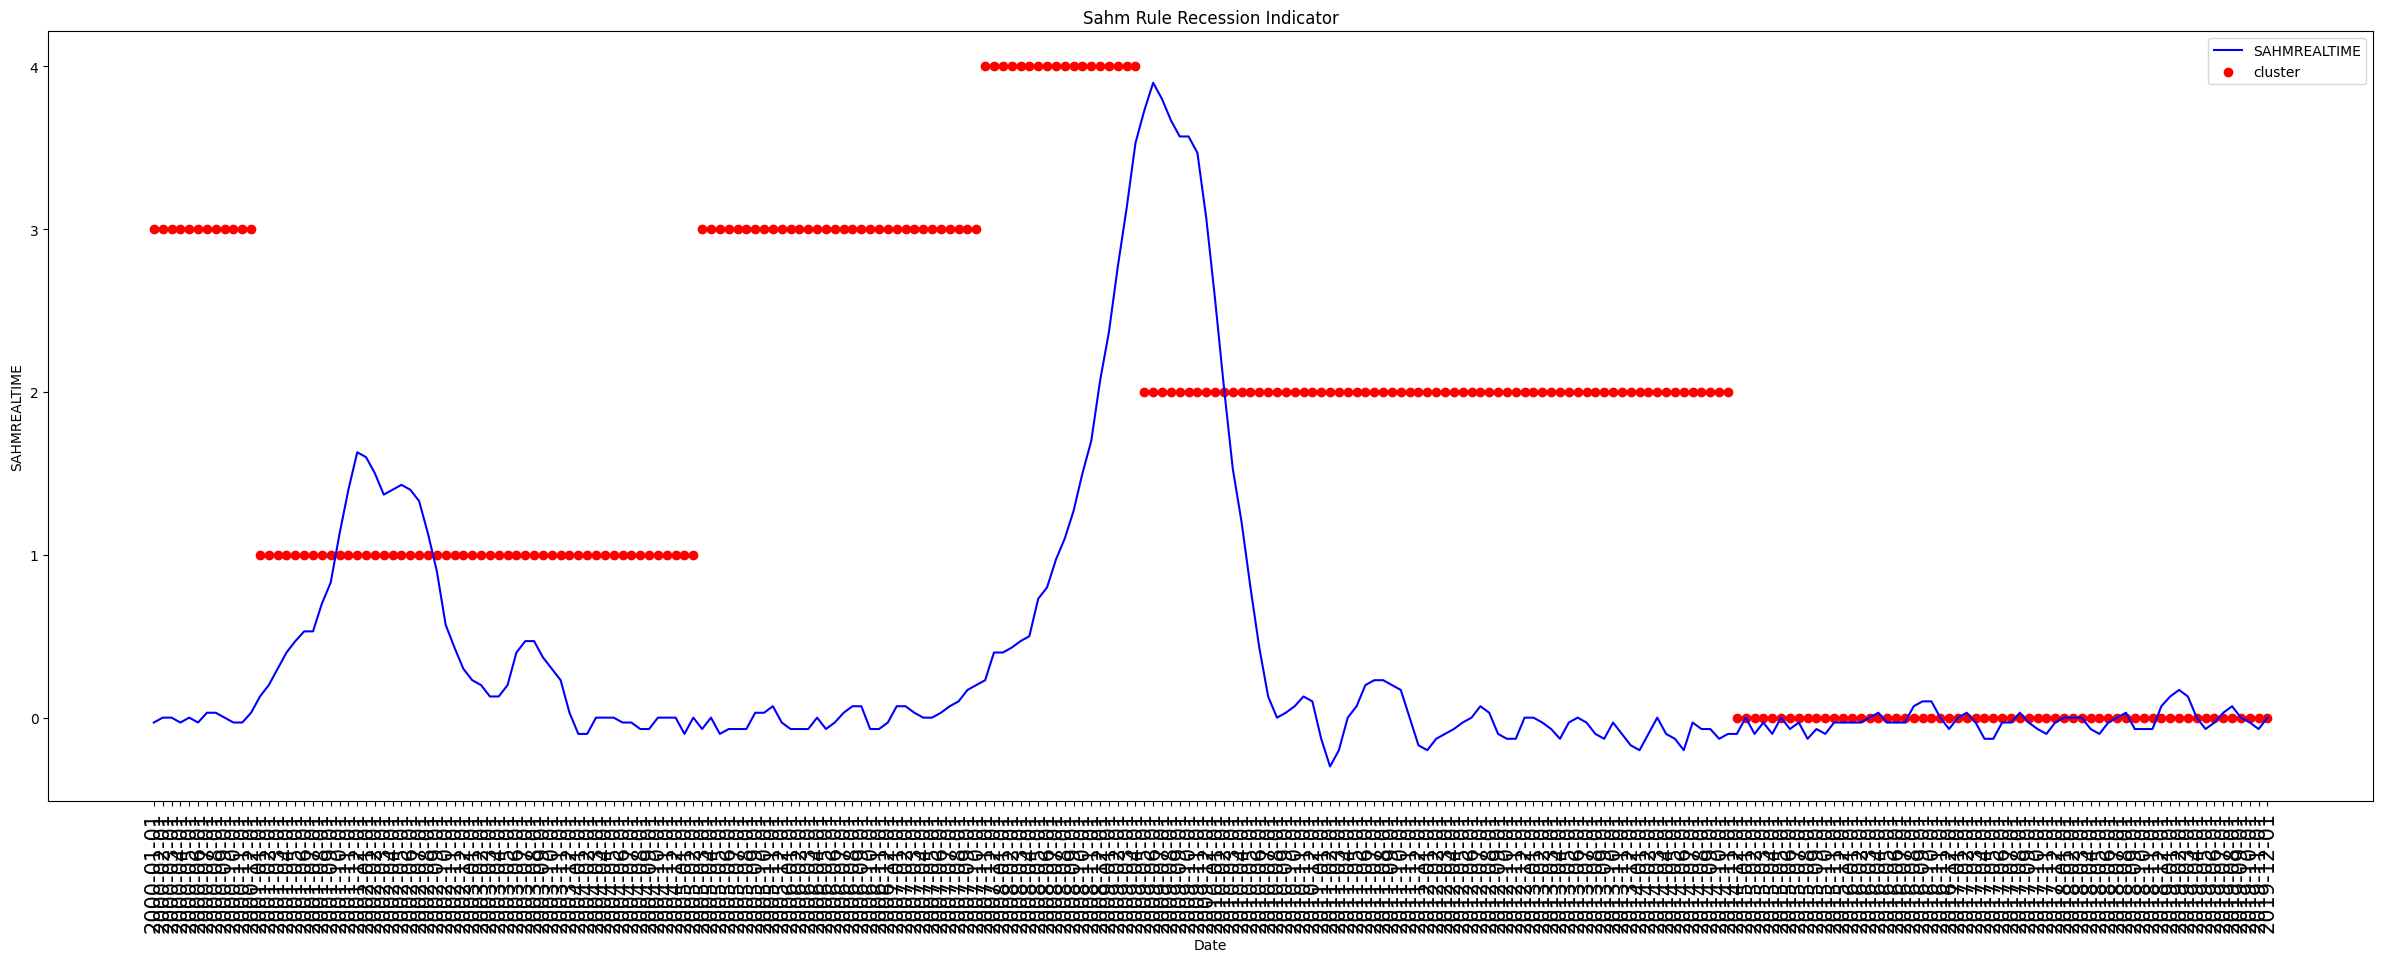

In [287]:
# SAHM지수와 클러스터 비교
plt.figure(figsize=(30, 10))

plt.plot(SAHM.DATE, SAHM['SAHMREALTIME'], label='SAHMREALTIME', color='blue')
plt.scatter(SAHM.DATE, SAHM['cluster'], label='cluster', color='red')

plt.title('Sahm Rule Recession Indicator')
plt.xlabel('Date')
plt.ylabel('SAHMREALTIME')
plt.xticks(rotation='vertical', fontsize=15)
plt.legend()
plt.show()

In [288]:
# pca_df 인덱스 재설정 및 필요없는 컬럼 삭제
scaled_pca.set_index('index',inplace=True)

In [289]:
# gdp 데이터 불러오기 및 cluster 컬럼 추가
gdp = pd.read_csv('./datasets/gdp.csv')
gdp['cluster'] = scaled_pca['gmm_cluster']

In [290]:
gdp.set_index('DATE',inplace=True)

In [291]:
gdp.head()

,USAGDPRQPSMEI,cluster
DATE,,
2000-01-31,4.224745,3
2000-02-29,4.224745,3
2000-03-31,4.224745,3
2000-04-30,5.244457,3
2000-05-31,5.244457,3


In [292]:
gdp['cluster'].value_counts()

cluster
2    67
0    61
1    50
3    44
4    18
Name: count, dtype: int64

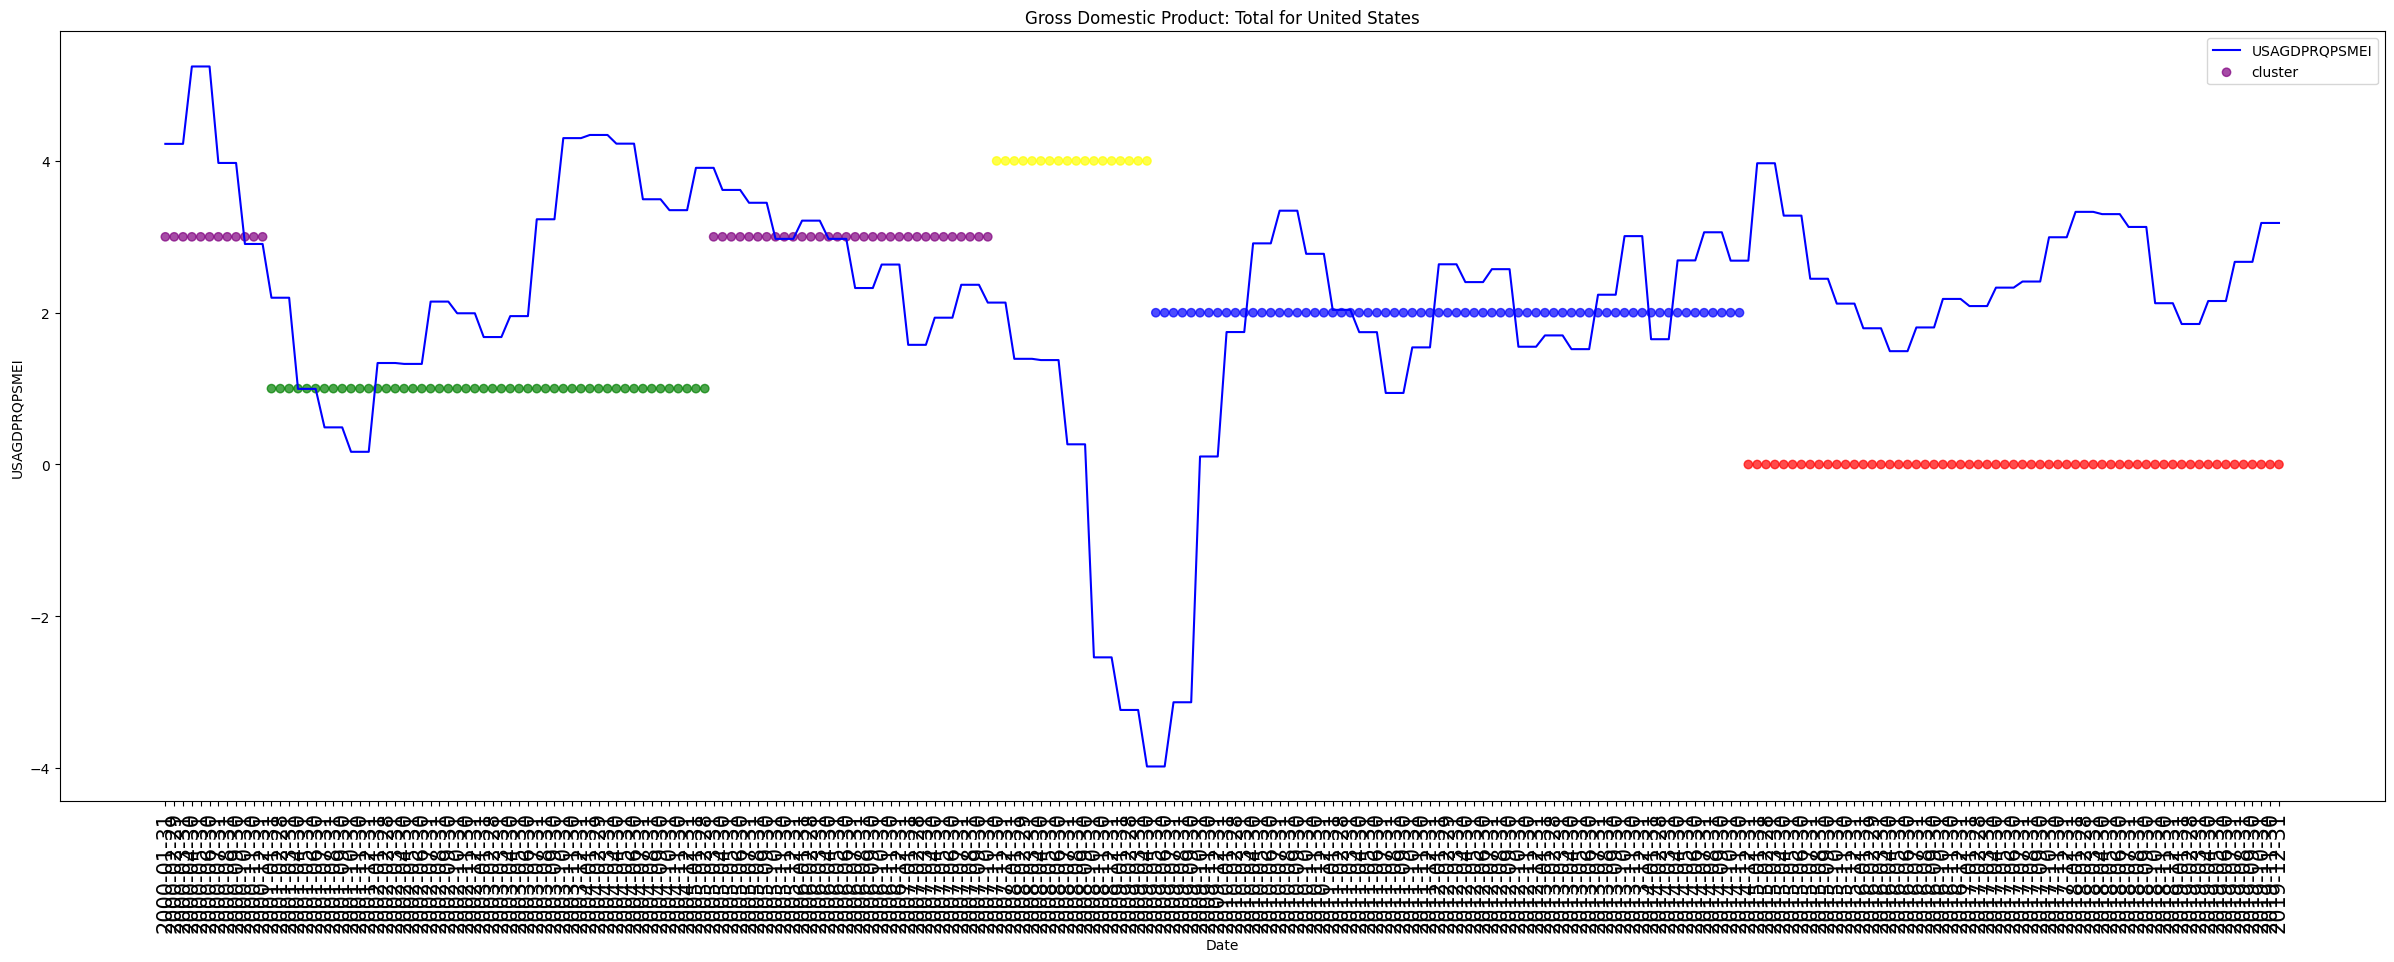

In [293]:
# GDP와 클러스터 비교
import seaborn as sns

# 각 클러스터에 대한 색상을 정의합니다.
cluster_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple', 4: 'yellow'}  # 클러스터의 수에 따라 조정

# 각 데이터 포인트에 대한 색상을 설정합니다.
colors = [cluster_colors[cluster] for cluster in gdp['cluster']]

# 그래프를 그립니다.
plt.figure(figsize=(30, 10))

plt.plot(gdp.index, gdp['USAGDPRQPSMEI'], label='USAGDPRQPSMEI', color='blue')
plt.scatter(gdp.index, gdp['cluster'], c=colors, label='cluster', alpha=0.7)

plt.title('Gross Domestic Product: Total for United States')
plt.xlabel('Date')
plt.ylabel('USAGDPRQPSMEI')
plt.xticks(rotation='vertical', fontsize=15)
plt.legend()
plt.show()